In [1]:
import pandas as pd
import numpy as np
import os
import keras


%matplotlib inline
from matplotlib import pyplot as plt
from keras.models import Model
from keras import layers
from keras import Input
from sklearn.metrics import confusion_matrix,roc_curve, auc,recall_score,precision_score,f1_score

Using TensorFlow backend.


# 参数设置

In [2]:
# plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
# plt.rcParams['axes.unicode_minus'] = False


# from tensorflow import losses

wenben_back=20
total_day=2062
train_num=1650

wenben_term_back=20


wenben_sort=2
batch_size=8
epochs=5
LSTM_num=100
dense_num=20


mix_file='777888.xlsx'
first_columns='search_index'



test_num=total_day-train_num

# 数据转换类，返回多个字典？

In [3]:
class Data_maker:
    def __init__(self,train_num,test_num,fif_back,daily_back,wenben_back,wenben_term_back):
        self.train_num=train_num
        self.test_num=test_num
        self.fif_back=fif_back
        self.daily_back=daily_back
        self.wenben_back = wenben_back
        self.wenben_term_back=wenben_term_back
        

    def daily_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.wenben_back)) #总共1650个数据，由于扣除前面20个数据，所以为1630
            ### 先构造空（预测日长度*日后移）array
            samples = np.zeros((len(rows),
                                 self.daily_back,
                                 5))
            print(samples.shape)
            for j in rows:
                ### 每一个填入用于预测一天的开盘价到波动率矩阵
                samples[j] = data.loc[
                                  (data.index >= j) & (data.index < self.daily_back + j),
                                  'open':'volume_rate']
            print(data.index)
            print('日频训练array：',samples.shape)
            return samples
    def fif_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.wenben_back))
            samples = np.zeros((len(rows),
                                 self.fif_back,
                                 5))
            for j in rows:

                samples[j] = data.loc[
                              (data.index >= j * self.fif_back ) & (data.index < (j+1) * self.fif_back),
                              'open':]
            print('十五分钟训练array：',samples.shape)
            return samples
    def wenben_term_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.wenben_back)) #总共1489个数据，由于扣除前面20个数据，所以为1469
            samples = np.zeros((len(rows),
                                 self.wenben_term_back,
                                 wenben_sort))
            for j in rows:

                samples[j] = data.loc[
                                  (data.index >= j) & (data.index < self.wenben_term_back + j),
                                  first_columns:]
            print('文本长期训练array：',samples.shape)
            return samples

    def daily_test_data(self,data):
        while True:
            rows = list(range(self.test_num - self.wenben_back))
            print(self.test_num,self.wenben_back)
            print(rows)
            samples = np.zeros((len(rows),
                                self.daily_back,
                                 5))
            for j in rows:


                samples[j] = data.loc[
                                  (data.index >= self.train_num+j) & (data.index < self.train_num+self.daily_back + j),
                                  'open':'volume_rate']
            print('日测试array：',samples.shape)
            print('试一试index', data.index,'train_num',self.train_num)
            return samples

    def wenben_term_test_data(self, data):
        while True:
            rows = list(range(self.test_num - self.wenben_back))
            samples = np.zeros((len(rows),
                                self.wenben_term_back,
                                wenben_sort))
            for j in rows:
                samples[j] = data.loc[
                             (data.index >= self.train_num + j) & (data.index < self.train_num + self.wenben_term_back + j),
                             first_columns:]
            print('长期文本测试array：', samples.shape)
            return samples

    def fif_test_data(self,data):
        while True:
            rows = list(range(self.test_num - self.wenben_back))
            samples = np.zeros((len(rows),
                                self.fif_back,
                                 5))
            for j in rows:


                samples[j] = data.loc[
                                 (data.index >= 16*self.train_num+(j) * self.fif_back) & (data.index < 16*self.train_num+(j+1) * self.fif_back),
                                 'open':]
            print('十五分钟测试array：',samples.shape)
            return samples
    def target_train_data(self,data):
        while True:
            rows = list(range(self.train_num-self.wenben_back))
            targets = np.zeros((len(rows),))
            for j in rows:


                targets[j] = data.loc[data.index == j, 'close']#从target改为close，下同（为了预测价格，而不是之前的0或1）
            print('训练标签array',targets.shape)
            return targets
    def target_test_data(self,data):
        while True:
            rows = list(range(self.test_num-self.wenben_back))
            targets = np.zeros((len(rows),))
            for j in rows:


                targets[j] = data.loc[data.index == self.train_num+j, 'close'] ##出问题：应该是。而不是***：data.index == self.train_num+j
            print(targets.shape)
            return targets

# 设置类方法里的参数，赋值给origin_data_maker，仍然是一个class类

In [4]:
origin_data_maker=Data_maker(train_num=train_num,test_num=test_num,fif_back=16,daily_back=20,wenben_back=wenben_back,wenben_term_back=wenben_term_back)


# 读取原始数据（数据合二为一文件中是777888包含文本数据的预测数据，数据区间实验文件夹中有15分钟文件、日频文件、target文件）

In [5]:
new_dir='/Users/ccmac/Documents/毕业论文数据/数据二合为一'
dir='/Users/ccmac/Documents/毕业论文数据/数据区间试验'
# wenben_dir='/Users/ccmac/Documents/毕业论文数据/每日均值'
daily_df=pd.read_excel(os.path.join(new_dir,mix_file))
fif_df=pd.read_excel(os.path.join(dir,'fif_data.xlsx'))
target_df=pd.read_excel(os.path.join(dir,'target.xlsx'))
wenben_df=pd.read_excel(os.path.join(new_dir,mix_file))

# 历史数据标准化函数norm

In [6]:
def norm(df):
    x=df.copy()
    open_mean_value = df['open'].mean(axis=0)
    high_mean_value = df['high'].mean(axis=0)
    low_mean_value = df['low'].mean()
    close_mean_value = df['close'].mean()
    volumerate_mean_value = df['volume_rate'].mean()

    open_std_value = df['open'].std()
    high_std_value = df['high'].std()
    low_std_value = df['low'].std()
    close_std_value = df['close'].std()
    volumerate_std_value = df['volume_rate'].std()

    x['open']=(df['open']-open_mean_value)/open_std_value
    x['high'] = (df['high'] - high_mean_value) / high_std_value
    x['low'] =  (df['low'] - low_mean_value) / low_std_value
    x['close'] =  (df['close'] - close_mean_value) / close_std_value
    x['volume_rate'] = (df['volume_rate'] - volumerate_mean_value) / volumerate_std_value
    df=x
    return df

# 文本数据标准化函数wenben_norm

In [7]:
def wenben_norm(df):
    x=df.copy()
    sector_score_mean_value = df['sector_score'].mean(axis=0)
    search_index_mean_value = df['search_index'].mean(axis=0)
    # media_attention_mean_value = df['media_attention'].mean(axis=0)


    sector_score_std_value = df['sector_score'].std()
    search_index_std_value = df['search_index'].std()
    # media_attention_std_value = df['media_attention'].std()


    x['sector_score']=(df['sector_score']-sector_score_mean_value)/sector_score_std_value
    x['search_index'] = (df['search_index'] - search_index_mean_value) / search_index_std_value
    # x['media_attention'] = (df['media_attention'] - media_attention_mean_value) / media_attention_std_value

    df=x
    return df

# 目标target的标准化target_norm

In [8]:
def target_norm(df):
    x=df.copy()
    target_mean_value = df['close'].mean(axis=0)
    
    target_std_value = df['close'].std()
   
    x['close']=(df['close']-target_mean_value)/target_std_value
    


    df=x
    return df

# 数据标准化&切分函数

In [9]:
def split_data(train_num=train_num,wenben_back=wenben_back):
    daily_train_df=daily_df.loc[daily_df.index<train_num]
    daily_test_df=daily_df.loc[daily_df.index>=train_num]
    fif_train_df=fif_df.loc[fif_df.index<16*train_num]
    fif_test_df=fif_df.loc[fif_df.index>=16*train_num]
    wenben_train_df=wenben_df.loc[wenben_df.index<train_num]
    wenben_test_df=wenben_df.loc[wenben_df.index>=train_num]

    target_train_df=target_df.loc[target_df.index<train_num]
    target_test_df=target_df.loc[target_df.index>=train_num]

    daily_train_df=norm(daily_train_df)
    daily_test_df=norm(daily_test_df)
    fif_train_df=norm(fif_train_df)
    fif_test_df=norm(fif_test_df)
    wenben_train_df=wenben_norm(wenben_train_df)
    wenben_test_df = wenben_norm(wenben_test_df)
    
    target_train_df=target_norm(target_train_df)
    target_test_df=target_norm(target_test_df)


    return {'daily_train_df':daily_train_df,
            'daily_test_df':daily_test_df,
            'fif_train_df':fif_train_df,
            'fif_test_df':fif_test_df,
            'target_train_df':target_train_df,
            'target_test_df':target_test_df,
            'wenben_train_df':wenben_train_df,
            'wenben_test_df': wenben_test_df
            }

# 传入进行数据标准化&切分

In [10]:
daily_train_df=split_data()['daily_train_df']
print('日频训练切分：',daily_train_df.shape)
daily_test_df=split_data()['daily_test_df']
print('日频测试切分：',daily_test_df.shape)
fif_train_df=split_data()['fif_train_df']
print('十五分钟频训练切分：',fif_train_df.shape)
fif_test_df=split_data()['fif_test_df']
print('十五分钟频测试切分：',fif_test_df.shape)
target_train_df=split_data()['target_train_df']
print('训练目标切分：',target_train_df.shape)
target_test_df=split_data()['target_test_df']
print('测试目标切分：',target_test_df.shape)
wenben_norm_train_df=split_data()['wenben_train_df']
wenben_norm_test_df=split_data()['wenben_test_df']

日频训练切分： (1650, 9)
日频测试切分： (412, 9)
十五分钟频训练切分： (26400, 6)
十五分钟频测试切分： (6592, 6)
训练目标切分： (1650, 3)
测试目标切分： (412, 3)


# 调用类中的方法,处理原始数据

In [11]:
DM=origin_data_maker

daily_train=DM.daily_train_data(daily_train_df)
daily_test=DM.daily_test_data(daily_test_df)
fif_train=DM.fif_train_data(fif_train_df)
fif_test=DM.fif_test_data(fif_test_df)
target_train=DM.target_train_data(target_train_df)
target_test=DM.target_test_data(target_test_df)


wenben_term_train=DM.wenben_term_train_data(wenben_norm_train_df)
wenben_term_test=DM.wenben_term_test_data(wenben_norm_test_df)


(1630, 20, 5)
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649],
           dtype='int64', length=1650)
日频训练array： (1630, 20, 5)
412 20
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172

#  target_train 与target_test归一化

# 构建神经网络模型

In [12]:
def my_model(wenben_term_back,wenben_sort):

    ##### 一、模型搭建

    # 文本输入训练(!!!卷积滤镜行列先后)
    wenben_term_input=Input(shape=(wenben_term_back,wenben_sort),dtype='float32',name='wenben_term_input')
    Conv1D_fif=layers.Conv1D(16,1,strides=1)(wenben_term_input)
    LSTM_wenben_term=layers.LSTM(LSTM_num)(Conv1D_fif)
    
    # 15分钟频输入训练(!!!卷积滤镜行列先后)
    fif_min_input=Input(shape=(16,5),dtype='float32',name='fif_min_input')
    # fif_min_input=(8,16,4,1)
    Conv1D_fif=layers.Conv1D(16,1,strides=1)(fif_min_input)
    LSTM_fif=layers.LSTM(LSTM_num)(Conv1D_fif)

    # 日频输入训练
    daily_input=Input(shape=(20,5),dtype='float32',name='daily_input')
    # daily_input=(8,16,4,1)
    Conv1D_daily=layers.Conv1D(16,1,strides=1)(daily_input)
    LSTM_daily=layers.LSTM(LSTM_num)(Conv1D_daily)
    # 15分钟频训练结果和日频训练结果合并
    concatenated=layers.concatenate([LSTM_fif,LSTM_daily,LSTM_wenben_term],axis=-1) # axis=-1按照最后一个轴粘合

    alloy=layers.Dense(dense_num,activation='relu')(concatenated) #将粘合结果再接一个全连接层
    dropout=layers.Dropout(0.2)(alloy)
    output=layers.Dense(1,activation='sigmoid')(dropout)
    model=Model([fif_min_input,daily_input,wenben_term_input],output) #八股文：将输入和输出圈起来

    print(model.summary())
    model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),loss='mean_squared_error',metrics=['mae'])
    return model
    # reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, mode='auto')


# 模型滞后时长赋值

In [13]:
model=my_model(wenben_term_back=wenben_term_back,wenben_sort=wenben_sort)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
fif_min_input (InputLayer)      (None, 16, 5)        0                                            
__________________________________________________________________________________________________
daily_input (InputLayer)        (None, 20, 5)        0                                            
__________________________________________________________________________________________________
wenben_term_input (InputLayer)  (None, 20, 2)        0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 16, 16)       96          fif_min_input[0][0]              
___________

In [14]:
fif_train

array([[[-1.11923261, -1.10150364, -1.10618373, -1.11622335,
         -0.06785337],
        [-1.10055537, -1.11245064, -1.10220249, -1.11045753,
          0.15002803],
        [-1.11211321, -1.11116977, -1.11032839, -1.10787337,
         -0.89062775],
        ...,
        [-1.13201178, -1.13248291, -1.13717206, -1.13498467,
         -0.80908596],
        [-1.13147559, -1.11684434, -1.12184131, -1.12638075,
         -1.03799674],
        [-1.11729637, -1.10795269, -1.11297264, -1.11216039,
          1.45475648]],

       [[-1.1070641 , -1.09810783, -1.10315324, -1.10912811,
         -0.57429446],
        [-1.09619138, -1.09956743, -1.09043703, -1.09581893,
          0.19422662],
        [-1.09933405, -1.07655638, -1.0816575 , -1.09562474,
         -0.08618858],
        ...,
        [-1.10195541, -1.11167616, -1.10385144, -1.10626014,
         -0.2579975 ],
        [-1.11495799, -1.11341874, -1.11842457, -1.12076431,
          2.00845843],
        [-1.11312602, -1.10133981, -1.10597576, 

In [15]:
daily_train

array([[[-1.11654886, -1.12332939, -1.11291965, -1.10957362,
         -0.19399386],
        [-1.10539896, -1.09516527, -1.09865681, -1.10295514,
         -0.05778144],
        [-1.09362498, -1.11514377, -1.15920659, -1.17347336,
          0.06921732],
        ...,
        [-0.8796052 , -0.81375985, -0.86037052, -0.78602611,
          0.18537105],
        [-0.76566199, -0.77812626, -0.76991414, -0.77901883,
          0.80799084],
        [-0.80402684, -0.7612555 , -0.7785626 , -0.74379324,
         -0.46993712]],

       [[-1.10539896, -1.09516527, -1.09865681, -1.10295514,
         -0.05778144],
        [-1.09362498, -1.11514377, -1.15920659, -1.17347336,
          0.06921732],
        [-1.18197673, -1.05055624, -1.15874982, -1.03270953,
          0.9206707 ],
        ...,
        [-0.76566199, -0.77812626, -0.76991414, -0.77901883,
          0.80799084],
        [-0.80402684, -0.7612555 , -0.7785626 , -0.74379324,
         -0.46993712],
        [-0.7385245 , -0.75019939, -0.71748647, 

In [16]:
wenben_term_train

array([[[-0.71689611, -1.19584035],
        [-0.76004424, -0.66113693],
        [-0.7952672 , -1.24109882],
        ...,
        [-0.6121078 , -1.21065686],
        [-0.66494224, -1.05041223],
        [-0.69135946, -1.97417112]],

       [[-0.76004424, -0.66113693],
        [-0.7952672 , -1.24109882],
        [-0.76180539, -1.31247648],
        ...,
        [-0.66494224, -1.05041223],
        [-0.69135946, -1.97417112],
        [-0.67550913, -1.20212034]],

       [[-0.7952672 , -1.24109882],
        [-0.76180539, -1.31247648],
        [-0.79350605, -0.44122334],
        ...,
        [-0.69135946, -1.97417112],
        [-0.67550913, -1.20212034],
        [-0.7679694 , -0.69356377]],

       ...,

       [[ 0.11436575,  1.16221451],
        [ 0.05536729,  0.84994861],
        [ 0.15839445,  0.80444953],
        ...,
        [ 0.04568098,  0.72952171],
        [-0.04854044,  1.39037733],
        [-0.13307555,  2.19524567]],

       [[ 0.05536729,  0.84994861],
        [ 0.15839445,  0.80

In [17]:
target_train

array([-1.10957362, -1.10295514, -1.17347336, ...,  1.0229831 ,
        0.92393077,  0.95202991])

In [18]:
fif_test

array([[[-1.21052209, -1.2266912 , -1.21979433, -1.22619546,
          1.26672254],
        [-1.22614769, -1.21688235, -1.22551184, -1.21914697,
         -0.43321031],
        [-1.21708311, -1.19496786, -1.19864646, -1.20828848,
         -0.15534686],
        ...,
        [-1.22611315, -1.22473979, -1.22647623, -1.2202207 ,
         -0.13855957],
        [-1.22369593, -1.22827996, -1.22954164, -1.22543346,
          0.10975747],
        [-1.22859944, -1.22366911, -1.23227984, -1.22181397,
          0.75550572]],

       [[-1.22114059, -1.24002295, -1.23038549, -1.23466405,
          1.57646897],
        [-1.23952872, -1.25521976, -1.24839907, -1.24621527,
         -0.75955838],
        [-1.25461908, -1.24962457, -1.25261831, -1.24673481,
         -0.8203438 ],
        ...,
        [-1.19418859, -1.18046181, -1.18864083, -1.18575754,
          0.21720091],
        [-1.17965074, -1.18895821, -1.18225169, -1.18132409,
          0.5534925 ],
        [-1.18859445, -1.17856221, -1.18729756, 

In [19]:
daily_test

array([[[-1.20254829, -1.2302989 , -1.20582225, -1.22530271,
          0.00383804],
        [-1.21313354, -1.2140724 , -1.21203208, -1.18024372,
          0.40349047],
        [-1.15601443, -1.16625141, -1.1266727 , -1.1288564 ,
          1.3901667 ],
        ...,
        [-1.20853829, -1.19127933, -1.17829182, -1.16103449,
         -0.57497379],
        [-1.15753128, -1.13347307, -1.11869388, -1.0935771 ,
          0.32410325],
        [-1.09556066, -1.1399664 , -1.11937803, -1.16114661,
         -0.4627009 ]],

       [[-1.21313354, -1.2140724 , -1.21203208, -1.18024372,
          0.40349047],
        [-1.15601443, -1.16625141, -1.1266727 , -1.1288564 ,
          1.3901667 ],
        [-1.1134911 , -1.15845159, -1.10496191, -1.1570726 ,
         -0.98215295],
        ...,
        [-1.15753128, -1.13347307, -1.11869388, -1.0935771 ,
          0.32410325],
        [-1.09556066, -1.1399664 , -1.11937803, -1.16114661,
         -0.4627009 ],
        [-1.17397411, -1.21048846, -1.16490455, 

In [20]:
wenben_term_test

array([[[-1.1161804 ,  0.8286753 ],
        [-1.17473542,  1.42014824],
        [-1.10266771,  0.58638583],
        ...,
        [-0.99081261, -0.3681038 ],
        [-0.93976465,  0.27905833],
        [-0.87895752,  0.33116377]],

       [[-1.17473542,  1.42014824],
        [-1.10266771,  0.58638583],
        [-1.06137891,  1.14874611],
        ...,
        [-0.93976465,  0.27905833],
        [-0.87895752,  0.33116377],
        [-0.96303651, -0.28972709]],

       [[-1.10266771,  0.58638583],
        [-1.06137891,  1.14874611],
        [-1.16647766, -0.37704694],
        ...,
        [-0.87895752,  0.33116377],
        [-0.96303651, -0.28972709],
        [-1.06513244, -0.29197818]],

       ...,

       [[ 0.93324517,  0.82623275],
        [ 0.91297613,  0.36449835],
        [ 0.94525646, -1.03339529],
        ...,
        [ 0.69301946,  0.62605442],
        [ 0.71478992,  2.58597668],
        [ 0.69001664,  1.38435738]],

       [[ 0.91297613,  0.36449835],
        [ 0.94525646, -1.03

# model.fit(输入自变量x，因变量y)

In [21]:
history=model.fit(x=[fif_train,daily_train,wenben_term_train],y=target_train,batch_size=batch_size,validation_split=0.25,epochs=epochs)


2024-12-05 22:27:56.696278: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-05 22:27:56.696678: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.



Train on 1222 samples, validate on 408 samples
Epoch 1/5
1222/1222 [==============================] - 13s 10ms/step - loss: 0.8419 - mae: 0.6737 - val_loss: 0.0276 - val_mae: 0.1172
Epoch 2/5
1222/1222 [==============================] - 8s 7ms/step - loss: 0.8067 - mae: 0.6323 - val_loss: 0.0252 - val_mae: 0.1022
Epoch 3/5
1222/1222 [==============================] - 9s 7ms/step - loss: 0.8049 - mae: 0.6265 - val_loss: 0.0244 - val_mae: 0.0940
Epoch 4/5
1222/1222 [==============================] - 9s 7ms/step - loss: 0.8045 - mae: 0.6251 - val_loss: 0.0244 - val_mae: 0.0950
Epoch 5/5
1222/1222 [==============================] - 13s 11ms/step - loss: 0.8048 - mae: 0.6265 - val_loss: 0.0243 - val_mae: 0.0950


# model.evaluate(输入测试数据)，进行模型预测性能测试（已改为评价指标mse，mae）

In [22]:
test_mse_score,test_mae_score = model.evaluate([fif_test,daily_test,wenben_term_test],y=target_test)
print(test_mse_score,test_mae_score)

392/392 [==============================] - 1s 1ms/step
0.5826183251504388 0.5583370923995972


# 生成均值和标准差，作为将预测值还原为收盘价的基础

In [23]:
daily_test_df=daily_df.loc[daily_df.index>=train_num]

close_mean_value = daily_test_df['close'].mean()
close_std_value = daily_test_df['close'].std()


# 将y还原成指数形式的函数

In [24]:
def gen_y_pred():
    y_predict=model.predict([fif_test,daily_test,wenben_term_test],batch_size=1).reshape(test_num-wenben_back).tolist() ###batch_size要设为1，不然evaluate和predict结果不同
    y_pred=[]
    for i in y_predict:
        y= i*close_std_value + close_mean_value
        y_pred.append(y)
       
    return y_pred

In [25]:
y_predict=model.predict([fif_test,daily_test,wenben_term_test],batch_size=1).reshape(test_num-wenben_back).tolist()

In [26]:
y_predict

[3.2809347771944886e-07,
 3.232968879274267e-07,
 3.2308759045918123e-07,
 3.23969999271867e-07,
 3.2091958246383e-07,
 3.173138622969418e-07,
 3.2736619459683425e-07,
 3.421044993956457e-07,
 3.3239749086533266e-07,
 3.1959891089172743e-07,
 3.03347746921645e-07,
 3.0419744234677637e-07,
 2.972771255826956e-07,
 2.97108499580645e-07,
 2.977518249736022e-07,
 2.923304691648809e-07,
 2.7887665510206716e-07,
 3.4132659720853553e-07,
 3.180021508342179e-07,
 3.6012443160871044e-07,
 3.484213380033907e-07,
 3.505544441395614e-07,
 3.7386604390121647e-07,
 3.955849479098106e-07,
 3.7385285622804076e-07,
 3.833541200037871e-07,
 3.833665687125176e-07,
 4.092014762591134e-07,
 3.9625703607271134e-07,
 4.039453642690205e-07,
 4.53559835023043e-07,
 4.1826947949630267e-07,
 4.41226092107172e-07,
 4.1430345731896523e-07,
 4.094926850939373e-07,
 3.8432600035775977e-07,
 3.8530330925823364e-07,
 3.8099165067251306e-07,
 3.9685644992459856e-07,
 3.800637102813198e-07,
 3.929536660507438e-07,
 3.73

# 无需还原的代码

In [27]:
# y_predict=model.predict([fif_test,daily_test,wenben_long_term_test,wenben_short_term_test],batch_size=1).reshape(test_num-wenben_back).tolist() ###batch_size要设为1，不然evaluate和predict结果不同


# 需还原时，制作y

In [28]:
y_pred=gen_y_pred()
print(y_pred)

[4581.066061579081, 4581.0660587981465, 4581.066058676802, 4581.066059188399, 4581.066057419848, 4581.066055329347, 4581.066061157422, 4581.066069702299, 4581.066064074434, 4581.066056654158, 4581.066047232166, 4581.066047724797, 4581.066043712582, 4581.066043614816, 4581.066043987799, 4581.066040844642, 4581.066033044479, 4581.066069251292, 4581.066055728399, 4581.066080149775, 4581.066073364634, 4581.066074601352, 4581.066088116796, 4581.066100708838, 4581.06608810915, 4581.06609361773, 4581.066093624947, 4581.066108603339, 4581.066101098497, 4581.066105555985, 4581.066134321133, 4581.066113860726, 4581.0661271703575, 4581.066111561331, 4581.066108772174, 4581.0660941812, 4581.066094747818, 4581.066092248033, 4581.066101446021, 4581.066091710038, 4581.066099183291, 4581.066087830472, 4581.06608491061, 4581.066076229376, 4581.066050381404, 4581.066051871375, 4581.066040267462, 4581.0660428362735, 4581.066026155327, 4581.066033887039, 4581.066032908699, 4581.06603333896, 4581.066031942

# 

In [29]:
target_test_df=target_df.loc[target_df.index>=train_num]
target_test_df_paint=target_test_df['close'].tolist()
target_test_df_paint

[3870.668,
 3896.792,
 3926.585,
 3910.226,
 3891.226,
 3886.752,
 3952.387,
 3978.122,
 4002.813,
 3984.882,
 3991.875,
 3973.011,
 3902.978,
 3903.689,
 3899.982,
 3905.857,
 3877.089,
 3907.929,
 3947.039,
 3907.864,
 3889.598,
 3849.995,
 3878.206,
 3891.653,
 3875.619,
 3862.303,
 3828.671,
 3836.059,
 3851.087,
 3849.819,
 3879.364,
 3902.385,
 3895.447,
 3900.384,
 3902.749,
 3891.024,
 3968.221,
 3987.546,
 4041.8,
 4032.783,
 4027.15,
 4017.253,
 3967.096,
 3992.958,
 3990.867,
 4025.988,
 4022.028,
 4081.633,
 4096.582,
 4152.241,
 4144.965,
 4129.295,
 4160.227,
 4112.317,
 4164.37,
 4163.185,
 4203.988,
 4189.886,
 4166.734,
 4149.043,
 4154.853,
 4185.83,
 4114.309,
 4131.931,
 4003.901,
 3688.358,
 3785.638,
 3828.527,
 3899.775,
 3899.869,
 3916.005,
 3952.464,
 3984.433,
 3959.919,
 3987.734,
 4077.424,
 4057.511,
 4051.311,
 4144.656,
 4149.49,
 4132.839,
 4123.854,
 4073.015,
 4084.876,
 3940.049,
 4069.666,
 4091.362,
 4115.052,
 4206.725,
 4138.507,
 3997.133,
 4082

In [30]:
target_train

array([-1.10957362, -1.10295514, -1.17347336, ...,  1.0229831 ,
        0.92393077,  0.95202991])

#  根据实际数据与预测数据进行绘图

/opt/anaconda3/envs/thesis/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/thesis/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/thesis/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/thesis/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/thesis/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B})

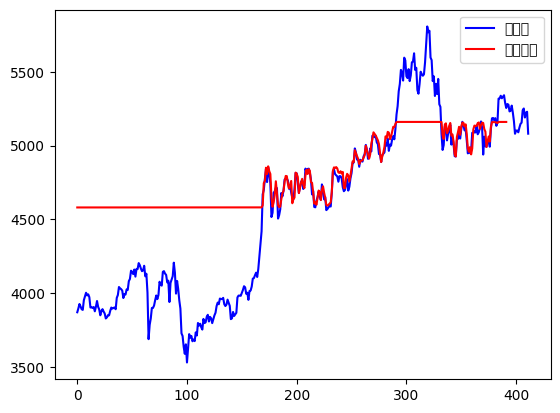

In [31]:

 
# 绘制原价格和预测价格
plt.plot(target_test_df_paint, color='blue', label='原价格')
plt.plot(y_pred, color='red', label='预测价格')
 
# 添加图例
plt.legend()
 
# 显示图表
plt.show()
